# 2022 Cogo Ride Exploration and Visualization
## by Fisayo Sofuwa

## Introduction
The [Cogo Bike](https://en.wikipedia.org/wiki/CoGo) Share system launched in July 2013 with a network of 300 bicycles and 30 stations located throughout downtown Columbus. Today, CoGo boasts around 90 stations and 600 bikes serving Columbus, Bexley, Upper Arlington, Grandview Heights and Easton. The system provides Columbus residents and visitors an additional transportation option for getting around town that is fun, easy, and affordable. 

CoGo is available for use 24 hours a day, 365 days a year and includes both classic pedal bikes and electric assist ebikes. The station network provides twice as many docking points as bicycles, assuring that an available dock to return your bicycle is always nearby. [here](https://cogo-sys-data.s3.amazonaws.com/index.html)

>**N.B**: The data used for this exploration is data from **`January`** to **`August`**.

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (8,6) # Adjust the comfiguretion of the plots we will create.

## Gathering and Assessing Data

In [2]:
# Get monthly CSV trip files from a folder and append data together
folder_name = 'data'

# Check if the file combined file exist and pass 
# else read the CSV files to append the data together
if os.path.exists("cogo_trips_2022.csv"):
    pass
else:
    csv_files = glob.glob(os.path.join(folder_name, "*.csv"))
    # Read each CSV file into DataFrame
    # This creates a list of dataframes
    trip_list = [pd.read_csv(file) for file in csv_files]
    # Concatenate all DataFrames
    full_trip   = pd.concat(trip_list, ignore_index=True)
    
    print(full_trip.shape)
    full_trip.head()
    
    # save the appended data to a .csv file for further usage
    full_trip.to_csv('cogo_trips_2022.csv', index=False)

In [3]:
biketrips22 = pd.read_csv('cogo_trips_2022.csv')
print(biketrips22.shape)
biketrips22.head()

(35887, 13)


ride_id  rideable_type           started_at             ended_at  \
0  864F163B1151C5DF   classic_bike  2022-01-20 17:57:24  2022-01-20 17:59:32   
1  13BB5ECDAB30A747   classic_bike  2022-01-28 18:49:25  2022-01-28 18:56:22   
2  99A68BC494138ACE   classic_bike  2022-01-27 19:05:01  2022-01-27 19:11:55   
3  84618D3D8240B379  electric_bike  2022-01-05 12:52:39  2022-01-05 13:38:37   
4  C2ABF3F51B578557  electric_bike  2022-01-17 16:14:24  2022-01-17 16:22:09   

       start_station_name start_station_id        end_station_name  \
0      Front St & Beck St              3.0  Bank St & Frankfort St   
1   Scioto Audubon Center              4.0  Bank St & Frankfort St   
2   Scioto Audubon Center              4.0  Bank St & Frankfort St   
3       Bicentennial Park              1.0   Scioto Audubon Center   
4  Neil Ave & Buttles Ave             22.0               City Hall   

  end_station_id  start_lat  start_lng    end_lat    end_lng member_casual  
0            8.0  39.950149 -83.000243  39.946596 -83.000349        member  
1            8.0  39.945884 -83.009046  39.946596 -83.000349        member  
2            8.0  39.945884 -83.009046  39.946596 -83.000349        member  
3            4.0  39.955956 -83.003256  39.945884 -83.009046        casual  
4            2.0  39.977384 -83.011621  39.962989 -83.004253        member

In [4]:
biketrips22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ride_id             35887 non-null  object 
 1   rideable_type       35887 non-null  object 
 2   started_at          35887 non-null  object 
 3   ended_at            35887 non-null  object 
 4   start_station_name  32522 non-null  object 
 5   start_station_id    32521 non-null  object 
 6   end_station_name    30870 non-null  object 
 7   end_station_id      30869 non-null  object 
 8   start_lat           35887 non-null  float64
 9   start_lng           35887 non-null  float64
 10  end_lat             35786 non-null  float64
 11  end_lng             35786 non-null  float64
 12  member_casual       35887 non-null  object 
dtypes: float64(4), object(9)
memory usage: 3.6+ MB


In [5]:
# check for null values
biketrips22.isna().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name    3365
start_station_id      3366
end_station_name      5017
end_station_id        5018
start_lat                0
start_lng                0
end_lat                101
end_lng                101
member_casual            0
dtype: int64

In [6]:
biketrips22.duplicated().sum()

0

There are no duplicates in the data

In [7]:
biketrips22.rideable_type.value_counts()

electric_bike    18408
classic_bike     17068
docked_bike        411
Name: rideable_type, dtype: int64

In [8]:
biketrips22.member_casual.value_counts()

casual    22203
member    13684
Name: member_casual, dtype: int64

## Issues

1. started_at and ended_at not in correct format.
2. Missing values start_station_id, start_station_name, end_station_id and end_station_name, and end_lat and end_lng.
3. Drop unnecessary columns(ride_id, start_station_id, end_station_id)
4. Create a trip duration column from started_at and ended_at.
5. Create trip start date, trip start hour of the day, day of the week and month

## Cleaning Data

In [9]:
# make a copy of the datframe
trips22 = biketrips22.copy()

In [10]:
# issue 1: Change started_at and ended_at to datetime format.
trips22['started_at'] = pd.to_datetime(trips22['started_at'])
trips22['ended_at'] = pd.to_datetime(trips22['ended_at'])

trips22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             35887 non-null  object        
 1   rideable_type       35887 non-null  object        
 2   started_at          35887 non-null  datetime64[ns]
 3   ended_at            35887 non-null  datetime64[ns]
 4   start_station_name  32522 non-null  object        
 5   start_station_id    32521 non-null  object        
 6   end_station_name    30870 non-null  object        
 7   end_station_id      30869 non-null  object        
 8   start_lat           35887 non-null  float64       
 9   start_lng           35887 non-null  float64       
 10  end_lat             35786 non-null  float64       
 11  end_lng             35786 non-null  float64       
 12  member_casual       35887 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(7)
me

In [11]:
# issue 2: drop missing values in end_station_id and end_station_name, and end_lat and end_lng.
trips22 = trips22.dropna(axis=0)
trips22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29242 entries, 0 to 35886
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             29242 non-null  object        
 1   rideable_type       29242 non-null  object        
 2   started_at          29242 non-null  datetime64[ns]
 3   ended_at            29242 non-null  datetime64[ns]
 4   start_station_name  29242 non-null  object        
 5   start_station_id    29242 non-null  object        
 6   end_station_name    29242 non-null  object        
 7   end_station_id      29242 non-null  object        
 8   start_lat           29242 non-null  float64       
 9   start_lng           29242 non-null  float64       
 10  end_lat             29242 non-null  float64       
 11  end_lng             29242 non-null  float64       
 12  member_casual       29242 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(7)
me

In [12]:
# issue 3: Drop unnecessary columns(ride_id, start_station_id, end_station_id)
trips22 = trips22.drop(columns = ['ride_id', 'start_station_id', 'end_station_id'])
trips22.columns

Index(['rideable_type', 'started_at', 'ended_at', 'start_station_name',
       'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [13]:
# issue 4: Create a trip duration column from started_at and ended_at.
trips22['duration_minute'] = trips22['ended_at'] - trips22['started_at']
trips22['duration_minute'] = trips22['duration_minute'].dt.components.minutes
trips22.sample(5)

rideable_type          started_at            ended_at  \
10643   classic_bike 2022-05-25 17:27:31 2022-05-25 17:50:49   
5061    classic_bike 2022-04-08 12:59:41 2022-04-08 13:03:25   
13939  electric_bike 2022-06-29 14:51:08 2022-06-29 15:11:02   
27384   classic_bike 2022-07-30 14:31:20 2022-07-30 14:55:06   
6150   electric_bike 2022-04-08 18:48:29 2022-04-08 19:07:56   

                  start_station_name               end_station_name  \
10643          Scioto Audubon Center                3rd St & Gay St   
5061        Northwest Blvd & 1st Ave             Yard St & Burr Ave   
13939                   North Market  Franklin Park at Fairwood Ave   
27384         Neil Ave & Buttles Ave              Bicentennial Park   
6150   St. Stephen's Community House  St. Stephen's Community House   

       start_lat  start_lng    end_lat    end_lng member_casual  \
10643  39.945884 -83.009046  39.963983 -82.998648        casual   
5061   39.979960 -83.032685  39.977019 -83.025868        member   
13939  39.972190 -83.003515  39.963267 -82.953245        casual   
27384  39.977416 -83.011574  39.955924 -83.003221        casual   
6150   40.000845 -82.968298  40.000750 -82.968277        casual   

       duration_minute  
10643               23  
5061                 3  
13939               19  
27384               23  
6150                19

In [14]:
# issue 5: Create trip start date, trip start hour of the day, day of the week and month
trips22['start_date'] = trips22['started_at'].dt.date
trips22['start_hourofday'] = trips22['started_at'].dt.hour
trips22['start_dayofweek'] = trips22['started_at'].dt.day_name()
trips22['start_month'] = trips22['started_at'].dt.month_name()

trips22.sample(3)

rideable_type          started_at            ended_at  \
31399   classic_bike 2022-08-25 16:31:01 2022-08-25 16:37:26   
27761  electric_bike 2022-07-23 23:14:45 2022-07-23 23:30:02   
23609   classic_bike 2022-07-07 14:04:42 2022-07-07 14:05:38   

           start_station_name        end_station_name  start_lat  start_lng  \
31399  Neil Ave & Buttles Ave        High St & Warren  39.977416 -83.011574   
27761            North Market  Champion Ave & Main St  39.972214 -83.003624   
23609         North Bank Park         North Bank Park  39.964999 -83.008771   

         end_lat    end_lng member_casual  duration_minute  start_date  \
31399  39.977479 -83.003507        member                6  2022-08-25   
27761  39.957748 -82.969183        casual               15  2022-07-23   
23609  39.964999 -83.008771        casual                0  2022-07-07   

       start_hourofday start_dayofweek start_month  
31399               16        Thursday      August  
27761               23        Saturday        July  
23609               14        Thursday        July

### What is the structure of your dataset?

> The original combined data contains data from January to August which is approximately 35,800 individual trip records with 13 variables collected. The variables can be divided into 3 categories:
> * trip duration: `started_at`, and `ended_at`.
> * station info: `start_station_name`, `start_station_id`, `end_station_name`, `end_station_id`, `start_lat`, `start_lng`,  `end_lat`, `end_lng`.
> * member info: `member_casual`, `rideable_type`, and `ride_id`

> Derived features/variables to assist exploration and analysis:
> * trip info: `duration_minute`, `start_date`, `start_hourofday`, `start_dayofweek`, `start_month`.


### What is/are the main feature(s) of interest in your dataset?

> I'm interested in exploring the bike trips' duration and rental events occurrance patterns, along with how these relate to the riders' characteristics, i.e user type(member or casual) to get a sense of how and what people are using the bike sharing services for. Sample questions to answer: When are most trips taken in term of time of day, day od week, or month of the year? How long does average trip take? Does the above depend on if a user is a casual or member user type?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Each trips' start date/time and duration information will help understand how long a trip usually takes and when. The member information user type(casual or member) will help us find out which group of the user type(member or casual) utilizes the services more, use the different groups to summarize bike usage data to see if there is any special pattern associated with the specific groups of riders.

## Univariate Exploration



A series of plots to first explore the trips distribution over hour of the day, day of the week, and month of the year.

In [15]:
def label(x, y,t):
    """
    Args:
    x: x-axis title
    y: y-axis title
    t: main title
    """
    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(t)
    plt.show()

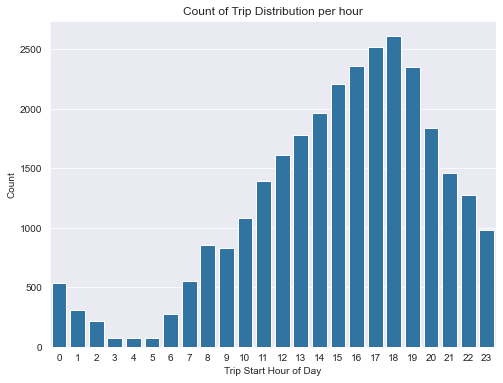

In [16]:
# trip distribution over day hours

base_color = sns.color_palette()[0]
sns.countplot(data=trips22, x='start_hourofday', color=base_color)
label('Trip Start Hour of Day', 'Count', 'Count of Trip Distribution per hour');

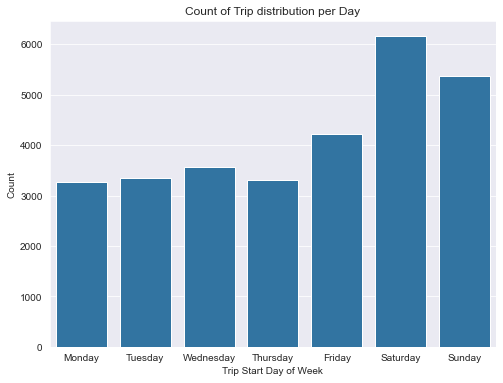

In [17]:
# trip distribution over weekdays
# change the start_dayofweek to categorical datatype
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdaycat = pd.api.types.CategoricalDtype(ordered=True, categories=weekday)
trips22['start_dayofweek'] = trips22['start_dayofweek'].astype(weekdaycat)

sns.countplot(data=trips22, x='start_dayofweek', color=base_color)
label('Trip Start Day of Week', 'Count', 'Count of Trip distribution per Day');

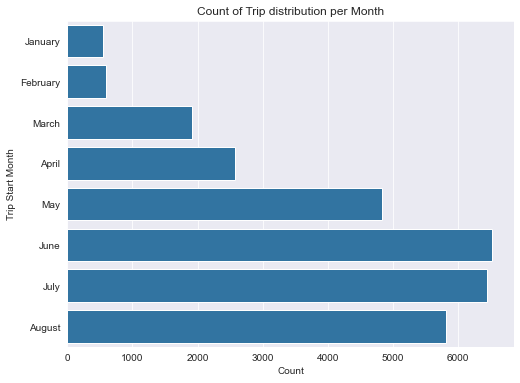

In [19]:
# trip distribution over months
# change the start_month to categorical datatype
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
monthcat = pd.api.types.CategoricalDtype(ordered=True, categories=month)
trips22['start_month'] = trips22['start_month'].astype(monthcat)

sns.countplot(data=trips22, y='start_month', color=base_color)
label('Count', 'Trip Start Month','Count of Trip distribution per Month');

The trip distribution over day hours is unimodel and peak late afternoon to evening around 15pm-19pm, during typical rush hours. Looking in combined with the distribution over day of week plot. With slight differnece during weekdays, Saturday having the higest usage. For the 2022, between January to August, the ride service usage increases with month except for decrease in July and August with June having the highest usage.

**N.B**: The data used for this exploration is data from **`January`** to **`August`**.

The next several plots are around user type(member or casual) and ride type(rideable_type) to have a sense of the typical user of the service.

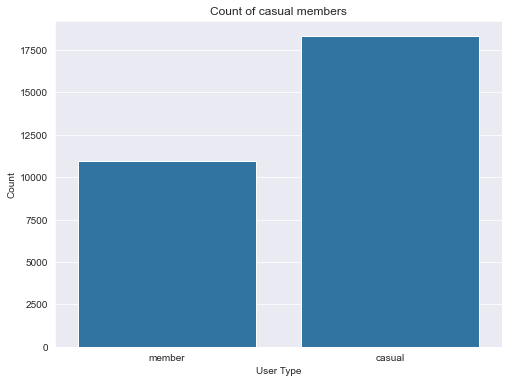

In [20]:
sns.countplot(data=trips22, x='member_casual', color=base_color)

label('User Type','Count', 'Count of casual members');

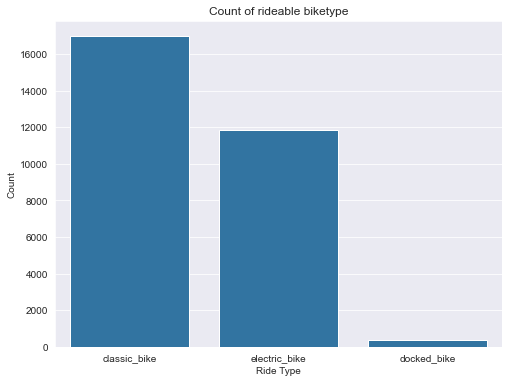

In [22]:
sns.countplot(data=trips22, x='rideable_type', color=base_color)

label('Ride Type','Count', 'Count of rideable biketype');

Most riders are casuals and ride type are classic bike with little docked bike usage.

Trip duration distribution plot next

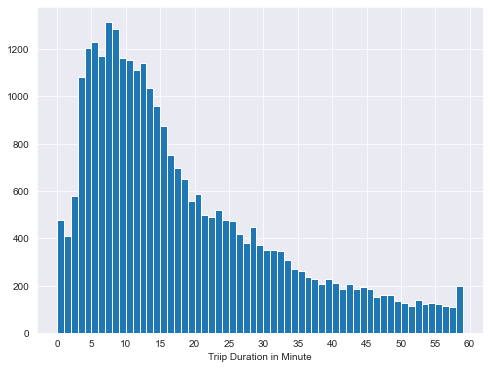

In [23]:
bins = np.arange(0, trips22['duration_minute'].max()+1, 1)
plt.hist(data=trips22, x='duration_minute', bins=bins, color=base_color)
plt.xlabel('Triip Duration in Minute')
ticks = np.arange(0, trips22['duration_minute'].max()+5, 5)
plt.xticks(ticks, ticks);

The trip distribution is right skewed with majority of the trips less than 1 hours within 4 to 13 minutes.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The number of trips peaked around 15-19pm with saturday been higher than other days. For the 2022, between January to August, the ride service usage increases with month except for almost same usage for January and February, and for fall in July and August.

>Most riders are casuals and ride type are classic bike.

>Most rides were quick and short, lasted between 4 to 13 minutes.

>There was no unusual points and no transformation was also needed due to straightforwardness of the data.

**N.B**: The data used for this exploration is data from **`January`** to **`August`**.



### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> The trips duration was extracted from the started_at and ended_at features. The start_date, start_hourofday, start_dayofweek, start_month was also gotten from started_at feature.

## Bivariate Exploration

How does the trip distribution vary between member and casual, electric bike, classic bike and docked bike?

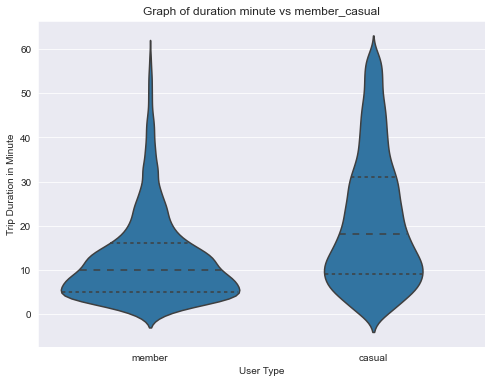

In [24]:
sns.violinplot(data=trips22, x='member_casual', y='duration_minute', color=base_color, inner='quartile')
label('User Type', 'Trip Duration in Minute', 'Graph of duration minute vs member_casual');

The trip duration distribution is much narrower for members compared to casual riders on the longer trip end overall. It seems like members have a more specific usage or targeted goal riding the bikes compared to casual who rented the bikes for long.

How does the trips duratiion distribution vary by ride type?

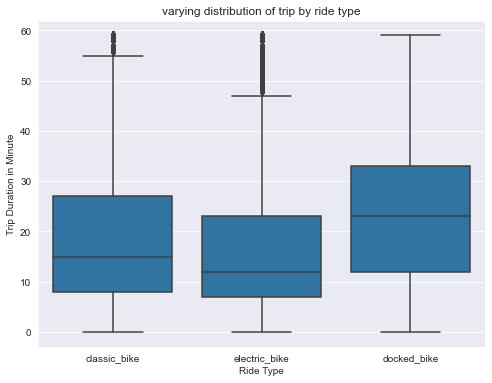

In [25]:
sns.boxplot(data=trips22, x='rideable_type', y='duration_minute', color=base_color)
label('Ride Type', 'Trip Duration in Minute', 'varying distribution of trip by ride type');

Though slight difference between electric and classic bikes. Docked bikes have higher trips duration.

Average Trip Duration by Hours of the Day.

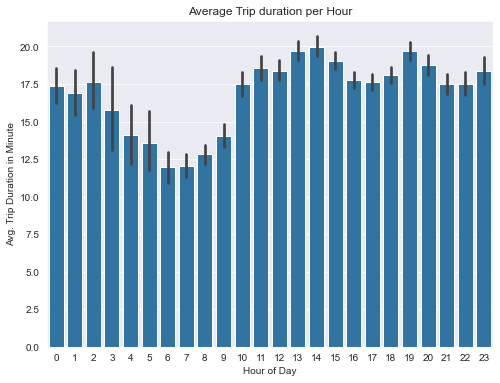

In [26]:
sns.barplot(data=trips22, x='start_hourofday', y='duration_minute', color=base_color)
label('Hour of Day', 'Avg. Trip Duration in Minute', 'Average Trip duration per Hour');

The riding trips are much shorted between 4am-9am with highest usage in 2pm.

Average Trip Duration on Weekdays

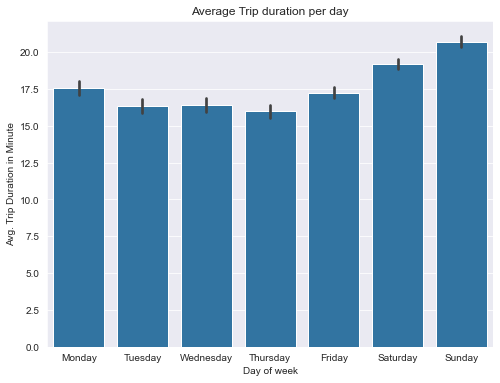

In [27]:
sns.barplot(data=trips22, x='start_dayofweek', y='duration_minute', color=base_color)
label('Day of week', 'Avg. Trip Duration in Minute', 'Average Trip duration per day');

The riding trips are much shorted on Monday through Friday compared to weekends. It indicates a stable and efficient usage of the sharing system  on normal work days, while more casual flexible use on weekends.

Average Trip Duration on Month

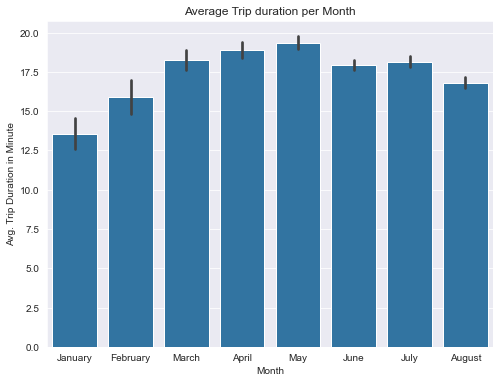

In [28]:
sns.barplot(data=trips22, x='start_month', y='duration_minute', color=base_color)
label('Month', 'Avg. Trip Duration in Minute', 'Average Trip duration per Month');

The average usage time show an increasing trend over the months from January to May, almost equal usage in June and July with a decrease in August.

Weekly usage between members and casuals

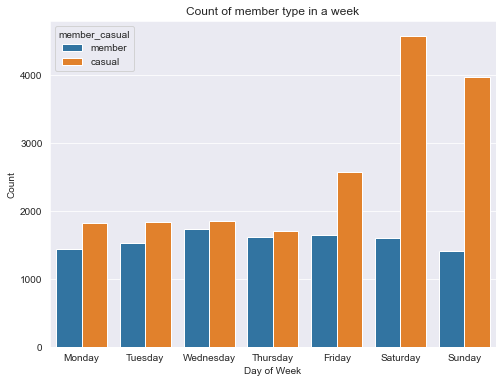

In [29]:
sns.countplot(data=trips22, x='start_dayofweek', hue='member_casual')
label('Day of Week', 'Count', 'Count of member type in a week');

The difference between member and casual during weekends is very large compared to weekdays. Which signify members and casual uses this bike sharing system as channel of commute to work places, with high usage at weekend by casual.

Monthly usage between members and casuals

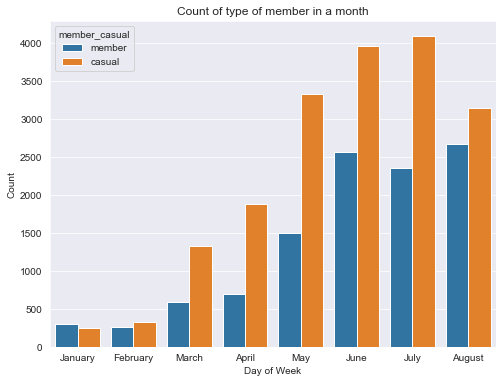

In [30]:
sns.countplot(data=trips22, x='start_month', hue='member_casual')
label('Day of Week', 'Count', 'Count of type of member in a month');

The plot above shows the increasing pattern of trips with larger trips made by members with the exception of January and February having very slight difference between casual and members.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> There are a lot of member than casual users and the riding habit varies alot between both user type. Members and casuals uses the bike sharing system for work commute thus having low average trip between on work days (Mon-Fri) whereas casual tends to ride for fun especially over the weekend. 


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> It is interesting to see that docked bike type have higher average trip duration with little difference in electric and classic bikes.

## Multivariate Exploration

How does the average trip duration vary between member and casual, and ride type

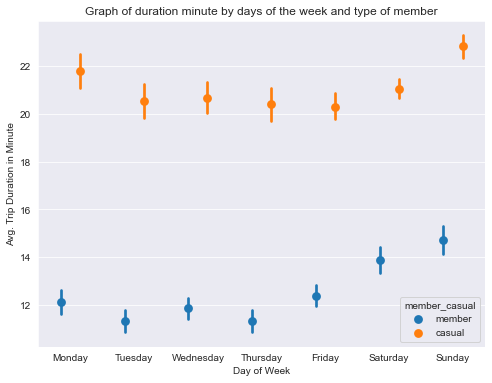

In [31]:
sns.pointplot(data=trips22, x='start_dayofweek', y='duration_minute', hue='member_casual', dodge=0.3, linestyles='')
label('Day of Week', 'Avg. Trip Duration in Minute', 'Graph of duration minute by days of the week and type of member');

It can be seen from the above plot that members ride much shorter/quicker trips compared to casual  on each day of the week. Both user types have decrease trip duration trend between Monday to Thursday and increase between Friday to Sunday.

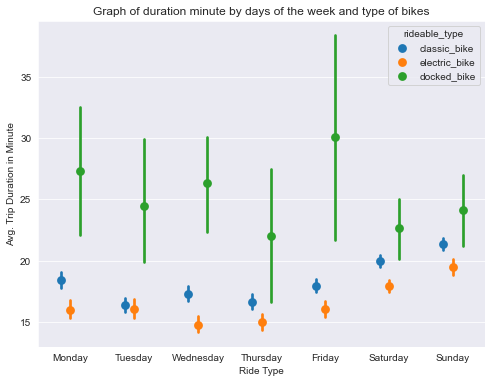

In [32]:
sns.pointplot(data=trips22, x='start_dayofweek', y='duration_minute', hue='rideable_type', dodge=0.3, linestyles='')
label('Ride Type', 'Avg. Trip Duration in Minute', 'Graph of duration minute by days of the week and type of bikes');

From the above plot, docked bikes high avearge trip duration compared with to classic and elcectric bikes with little differnce between both.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The multivariate exploration strengthened some of the patterns discovered in the previous bivariate exploration as well as univariate exploration, the relationship between the multiple variables plotted are visualized altogether and information are presented combined. The short and efficient period of usage  for member between Monday through Friday indicate the use primarily for work commute. The more higher and flexible pattern of casual use shows that they are taking advantage of the bike sharing system quite differntly heavily over the weekends for city tour or leisure purposs probably.

### Were there any interesting or surprising interactions between features?

> The interactions between features are all suplementing each other and quite make sense when looked at combined. There is no big surprised, except for high average trip duration of docked bikes compared to the electric and classic bikes.